# Mask R-CNN - Evaluation on Camus Dataset


This notebook runs tests with Mask R-CNN model using echocardiogram images from the [Camus Project](https://www.creatis.insa-lyon.fr/Challenge/camus/) dataset that have been avoided in the training.

Authors: **Alex Carneiro** and **Luiz Tauffer**

In [1]:
%load_ext autoreload
%autoreload 2

# Imports and definition of constant paths
import os
import sys
from tqdm import tqdm

import numpy as np

from camus_image_processing import fix_resolution, pre_filter, eval_detection
from camus_image_processing import CamusConfig, CamusDataset, InferenceConfig

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Alex Carneiro\Anaconda3\envs\DeepLearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Load trained model to be tested

In [2]:
inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = os.path.join(MODEL_DIR, "mask_rcnn_camus_chambers.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights from  D:\AC Data\TaufferConsulting\Tauffer_fork\Mask_RCNN\logs\mask_rcnn_camus_chambers.h5


## 2. Load images that have been avoided in the training

In [5]:
config = CamusConfig()
dataset_val = CamusDataset()

# Patients that have ids with endding in 1 are used to validate/test the model
dataset_val.load_camus("../../../../data_chambers/patient*[1]/", config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
# dataset_val.load_camus("../../../../train/patient*[1]/", config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

100%|█████████████████████████████████████████| 35/35 [00:00<00:00, 3899.40it/s]


## 3. Run test with one image for illustration

The evaluation metric employed is the IoU -- Intersection over Union

https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

Given $GT$ as the ground truth regions for the current image and $Detection$ the detected regions obtained from the model, we measure the detection accuracy for each region $i$ with the equation:

$$IoU_i = \dfrac{|GT \cap Detection|}{|GT \cup Detection|}$$

where $|C|$ means the size of the set $C$.

The regions are:
1. ventricule
2. muscle
3. atrium

original_image           shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  128.00000  int32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   33.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  uint8


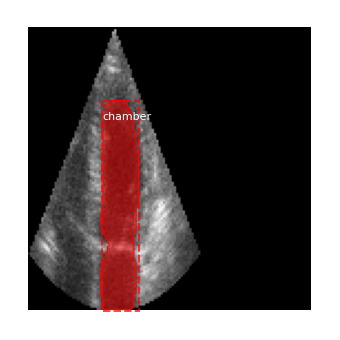

In [6]:
# Test on a random image from validation set
image_id = np.random.randint(0, len(dataset_val))
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_val.class_names, figsize=(6, 6))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int32
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


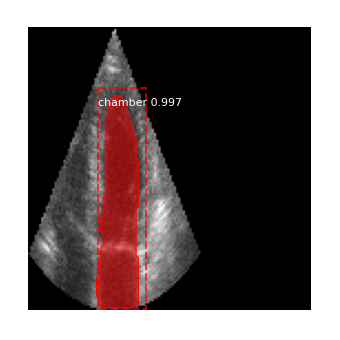

In [7]:
def get_ax(rows=1, cols=1, box_id=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    ax = plt.subplot(rows, cols, box_id)
    return ax

results = model.detect([original_image], verbose=True)

r = results[0]
plt.figure(figsize=(6,6))
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

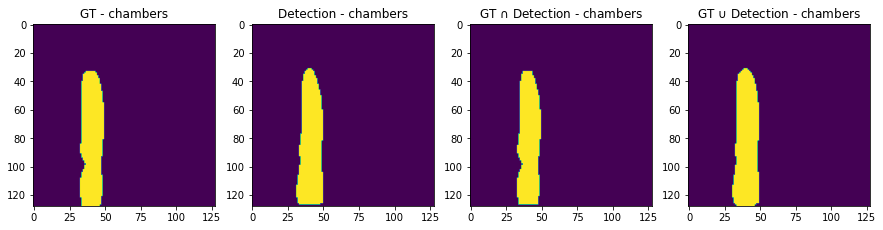

In [11]:
quality, merged_masks = eval_detection(gt_mask, r)

gt_mask = (gt_mask > 0)
plt.figure(figsize=(15, 4))
plt.subplot(1,4,1)
plt.title("GT - chambers")
plt.imshow(gt_mask[:,:,0]);
plt.subplot(1,4,2)
plt.title("Detection - chambers")
plt.imshow(merged_masks[1]);
plt.subplot(1,4,3)
plt.title("GT $\cap$ Detection - chambers")
plt.imshow(gt_mask[:,:,0] & merged_masks[1]);
plt.subplot(1,4,4)
plt.title("GT $\cup$ Detection - chambers")
plt.imshow(gt_mask[:,:,0] | merged_masks[1]);

## 4. Run test with all loaded images

In [12]:
qualities = []
for image_id in tqdm(range(len(dataset_val)), ncols=80):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)

    results = model.detect([original_image], verbose=False)
    r = results[0]

    quality, _ = eval_detection(gt_mask, r)
    qualities.append(quality)

100%|███████████████████████████████████████████| 73/73 [00:21<00:00,  3.73it/s]


In [13]:
mean_quality = dict([(key, np.mean([q[key] for q in qualities])) for key in qualities[0].keys()])
mean_quality

{1: 0.8095015567862766, 2: 0.0, 3: 0.0}

### Results per total epochs of traning

####  1 epoch:   {1: 0.4968811228019458, 2: 0.23472957400356156, 3: 0.4381529946604371}
####  3 epochs: {1: 0.6593114711441245, 2: 0.41243324742298687, 3: 0.5996829301258129}
####  5 epochs: {1: 0.6774825352332781, 2: 0.4200807824106857,   3: 0.6425511381916152}
#### 10 epochs: {1: 0.7800522888825432, 2: 0.5662842830401258,   3: 0.6960958824033797}
#### 12 epochs: {1: 0.752768551278617, 2: 0.5577423334261422, 3: 0.7288713684009502}
#### 15 epochs: {1: 0.7161279587439695, 2: 0.5291913435634776, 3: 0.7221492980169737}